In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


In [2]:
! pip install phik -q;
! pip install catboost -q;
! pip install shap -q;

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_auc_score


from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from joblib import Parallel, delayed



import shap
import phik
from time import time

sns.set_style('darkgrid')
sns.set(font_scale=1.3)

In [4]:
import psutil

print("Number of CPUs:", psutil.cpu_count(logical=False))  # Физические процессоры
print("Number of Logical CPUs:", psutil.cpu_count(logical=True))  # Логические процессоры (включая Hyper-Threading)

Number of CPUs: 2
Number of Logical CPUs: 4


In [5]:
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')

In [6]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [8]:
train.isna().sum().sort_values()

var_190    0
var_191    0
var_192    0
var_193    0
var_194    0
          ..
var_11     0
var_12     0
var_13     0
var_199    0
ID_code    0
Length: 202, dtype: int64

In [9]:
train.drop('ID_code', axis = 1).duplicated().sum()

0

In [10]:
train = train.drop('ID_code', axis = 1)
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [11]:
RANDOM_STATE = 42


X = train.drop('target', axis = 1)

y = train['target']

num_col = list(X)

In [12]:
num_pipe = Pipeline(
    [
        ('num', StandardScaler())
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col)
    ]
)


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [13]:
param_DTC = {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__min_samples_split': range(2, 15)
}
    
param_RFC = {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'models__n_estimators' : range(50, 300)
}

param_SVC = {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__kernel': ['linear', 'poly', 'rbf'],
        'models__degree': range(2, 5),
        'models__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
        'models__coef0': [0.0, 0.1, 0.5, 1.0]
}


param_grid_lr = {
        'models': [LogisticRegression()],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__max_iter' : range(100, 1000)
        
}


param_grid_CBR = {
        'models': [CatBoostClassifier(eval_metric = 'AUC',random_state=RANDOM_STATE)],
        'models__iterations': [500, 1000, 1500],
        'models__learning_rate': [0.1, 0.15, 0.2],
        'models__l2_leaf_reg': range(1, 8),
        'models__border_count': range(32, 224, 64),
        'models__bagging_temperature': [0, 0.5, 1]
}

models_params = [param_grid_lr]#, param_DTC, param_RFC, param_SVC, param_grid_CBR]

In [14]:
best_models = []
for i in models_params:
    randomized_search = RandomizedSearchCV(
        pipe_final,
        i,
        scoring = 'roc_auc',
        error_score='raise',
        random_state = RANDOM_STATE,
        n_jobs= -1,
        n_iter= 20,
        cv=3
    )
    
    randomized_search.fit(X, y)
    
    best_models.append({
    'best_model' : randomized_search.best_params_['models'],
    'roc_auc' : round(randomized_search.best_score_, 3),
    'learn_time' : round(randomized_search.refit_time_,2)
    })
best_models = pd.DataFrame(best_models)

In [15]:
best_models

,best_model,roc_auc,learn_time
0,"LogisticRegression(C=0.01, max_iter=960)",0.859,1.43


In [16]:
pca_train = PCA()
pca = pca_train.fit(X)

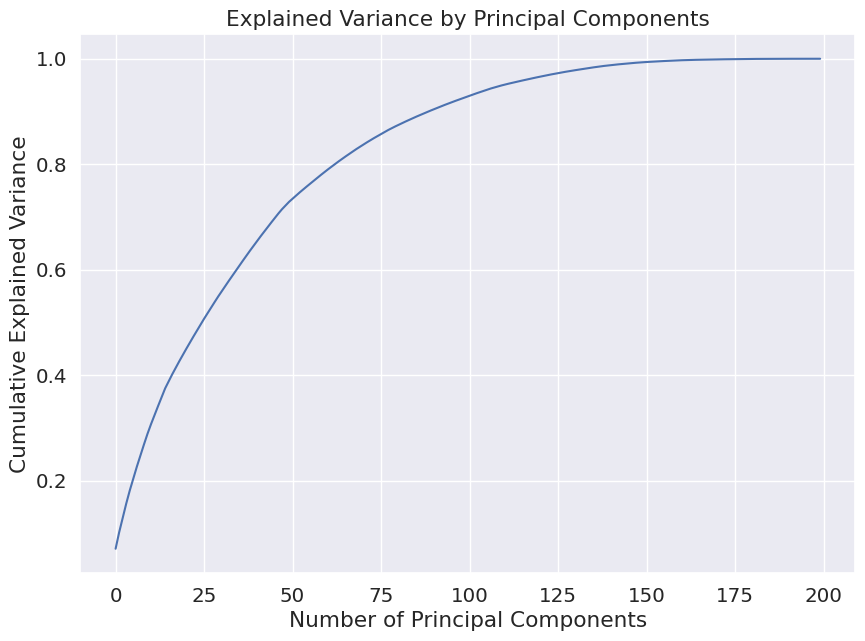

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

In [18]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f'Number of components to retain 90% of variance: {n_components}')

Number of components to retain 90% of variance: 90


In [19]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

X_pca = pd.DataFrame(X_pca)

In [20]:
num_col_pca = list[X_pca]

In [21]:
X_pca.shape

(200000, 90)

In [22]:
num_pipe_pca = Pipeline(
    [
        ('num', StandardScaler())
    ]
)

data_preprocessor_pca = ColumnTransformer(
    [
        ('num', num_pipe, num_col_pca)
    ]
)


pipe_final_pca = Pipeline([
    ('preprocessor', data_preprocessor_pca),
    ('models', LogisticRegression())
])

In [23]:
best_models_pca = []
for i in models_params:
    randomized_search_pca = RandomizedSearchCV(
        pipe_final_pca,
        i,
        scoring = 'roc_auc',
        error_score='raise',
        random_state = RANDOM_STATE,
        n_jobs= 2,
        n_iter= 20,
        cv=3
    )
    
    randomized_search_pca.fit(X_pca, y)
    
    best_models_pca.append({
    'best_model' : randomized_search_pca.best_params_['models'],
    'roc_auc' : round(randomized_search_pca.best_score_, 3),
    'learn_time' : round(randomized_search_pca.refit_time_,2)
    })
best_models_pca = pd.DataFrame(best_models_pca)

In [24]:
best_models_pca 

,best_model,roc_auc,learn_time
0,"LogisticRegression(C=0.01, max_iter=960)",0.772,0.87


In [25]:
best_models

,best_model,roc_auc,learn_time
0,"LogisticRegression(C=0.01, max_iter=960)",0.859,1.43
